In [1]:
from copy import deepcopy as copy
import itertools
# from netgraph import InteactiveGraph # pip install netgraph
from functools import reduce
from itertools import product
from operator import itemgetter

import cvxpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy
from numpy.linalg import matrix_rank as rank
from scipy.linalg import block_diag, fractional_matrix_power
from utils.Adversary import Adversary
from utils.Conversions import hamming_dist as dist
from utils.Conversions import to_str, visualize
from utils.Problems import Problem, exact_k, threshold_k
from utils.Solvers import adv_solver, instance_mask, ket, partial, type_mask, span_solver

In [2]:
def partial_identity(size, id_size, index):
    sub_mat = np.zeros((size, size))
    sub_mat[index, index] = 1
    return np.kron(sub_mat, np.eye(id_size))


def delta_mat(x, y, lang_size):
    n = len(x)
    mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if x[i] == x[j]:
                mat[i, j] = 1
    loc_mat = np.zeros((lang_size, lang_size))
    loc_mat[i, j] = 1
    return np.kron(loc_mat, mat)


def tensor_to_bmat(mat, dim1=None, dim2=None):
    assert mat.shape[0] == mat.shape[1]
    mat_size = mat.shape[0]
    if dim1 is None:
        size = int(np.sqrt(mat_size))
        dim1 = size
        dim2 = size
    bmat = [
        [mat[i * dim2 : (i + 1) * dim2, j * dim2 : (j + 1) * dim2] for i in range(dim1)]
        for j in range(dim1)
    ]
    print("bmat", bmat)

    return bmat


def ppt_span_bound(problem, p, r):
    n = problem.n
    lang_size = problem.len
    orig_size = n * lang_size
    pure_size = orig_size * r
    sep_size = pure_size * pure_size
    print("sep_size", sep_size, pure_size, orig_size, lang_size, n)
    X = cp.Variable((sep_size, sep_size), PSD=True)
    D = [partial_identity(lang_size, n, i) for i in range(lang_size)]
    Delta = [
        delta_mat(inst1, inst2, problem.len)
        for inst1, inst2 in list(product(problem.yes_instances, problem.no_instances))
    ]

    big_D = [
        reduce(np.kron, [d, np.eye(r), np.ones((pure_size, pure_size))])
        - np.eye(sep_size) / lang_size
        for d in D
    ]
    big_Delta = [
        reduce(np.kron, [mat, np.eye(r), np.ones((pure_size, pure_size))])
        - p * np.eye(sep_size)
        for mat in Delta
    ]
    constraints = [cp.trace(X) == 1, partial_transpose(X) >> 0]
    partial_inner = partial_inner_mat([pure_size, pure_size], 0)

    constraints += [
        partial_inner @ cp.multiply(mat, X) @ partial_inner.T == 0 for mat in big_Delta
    ]

    opt_prob = cp.Problem(cp.Minimize(0), constraints)
    opt_prob.solve(solver="SCS", verbose=True)
    return X.value


def partial_inner_mat(dims, i):
    left_I = np.eye(int(np.prod(dims[:i])))
    right_I = np.eye(int(np.prod(dims[i + 1 :])))
    left = reduce(np.kron, [left_I, np.ones((1, dims[i])), right_I])
    right = reduce(np.kron, [left_I, np.ones((dims[i], 1)), right_I])
    # print(big_A.shape, B.shape, left.shape, right.shape)
    return left


# <A,B>
def inner_mats(A, B, NP=False):
    if NP:
        return np.trace(A.T @ B)
    else:
        C = cp.multiply(A.T, B)
    return cp.trace(C)


# A is dims[i] by dims[i], B is \otimes_j dims[j] square
# want to apply <A,.> to the ith component of B


def index_pair_perms(row, col):
    return list(set(p for p in product([row, row[::-1]], [col, col[::-1]])))


def inv_map(map):
    return {image: preimage for preimage, image in enumerate(map)}


def symmetry_projection(pairs):
    proj = np.zeros((len(pairs), len(pairs)))
    inv_pairs = inv_map(pairs)
    for pair in pairs:
        pair_i = inv_pairs[pair]
        pair_rev = pair[::-1]
        pair_rev_i = inv_pairs[pair_rev]
        if not (pair == pair_rev and pair[0] != pair[1]):
            proj[pair_i, pair_rev_i] = 1
    return np.eye(len(pairs)) / 2 + proj / 2


def get_swap_mat(pairs):
    if isinstance(pairs, int):
        part_size = int(np.sqrt(pairs))
        assert part_size**2 == pairs
        pairs = list(product(range(part_size), range(part_size)))

    return 2 * symmetry_projection(pairs) - np.eye(len(pairs))


def dual_bound(objective_mask, constraint_mask, rank):
    pass

In [3]:
def constraint_contribution(var, const_mat, const):
    rank = var.shape[0] // const_mat.shape[0]
    return cp.kron(const * np.eye(var.shape[0]), var) - cp.kron(
        cp.multiply(const_mat, A)
    )


# def apply_partial(X, dim, part, pairs, inv_pairs):
#     id_dim = X.shape[0] // dim
#     new_X = np.zeros((id_dim, id_dim))
#     for pair in product(range(dim), range(dim)):
#         left = np.kron(ket(pair[0], dim), np.eye(id_dim))
#         right = np.kron(ket(pair[1], dim), np.eye(id_dim)).T
#         new_X = new_X + part[pair[1], pair[0]] * left @ X @ right

#     # for row in pairs:
#     #     for col in pairs:
#     #         r = inv_pairs[row]
#     #         c = inv_pairs[col]
#     #         print('r=',r,' c=', c, part[row[0], col[0]], X[r, c])
#     #         new_X[r, c] = cp.multiply(part[row[0], col[0]] * X[r, c])
#     print(new_X)


def partial_trace(X, dim):
    print(X)
    id_dim = X.shape[0] // dim
    pt = np.zeros((id_dim, id_dim))
    for i in range(dim):
        print(id_dim)
        right = cp.kron(np.array([ket(i, dim)]), np.eye(id_dim)).T
        left = right.T
        pt = pt + left @ X @ right
    return pt


def dual_sep_bound(obj_mat, const_mat, const, rank):
    n = obj_mat.shape[0]  # size of initial state
    labels = list(product(range(n), range(rank)))
    pairs = list(product(labels, labels))
    # pairs = [a + b for a,b in pairs]
    init_size = len(labels)  # size of pure representation of state
    size = len(pairs)  # separable size
    inv_pairs = inv_map(pairs)
    print("size", size)
    t = cp.Variable()
    A = cp.Variable((init_size, init_size))
    big_obj_mat = np.kron(obj_mat, np.eye(rank * init_size))
    rank_const_mat = np.kron(const_mat, np.eye(rank))
    witness_t = big_obj_mat - t * np.eye(size)
    witness_A = cp.kron(const * np.eye(init_size), A) - cp.kron(
        cp.multiply(rank_const_mat, A), np.ones((init_size, init_size))
    )
    witness = witness_t + witness_A
    proj = symmetry_projection(pairs)
    # print(np.linalg.eigvals(proj))
    visualize(proj, (pairs, pairs))
    constraints = [proj @ witness @ proj >> 0]
    opt_prob = cp.Problem(cp.Maximize(t), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    return A.value, t.value, witness.value


def apply_partial_2(target, mat, NP=False):
    size = target.shape[0]
    part_size = mat.shape[0]
    id_size = size // part_size
    id_mat = np.eye(id_size)
    big_mat = np.kron(mat, np.ones((id_size, id_size)))

    ones = np.ones((part_size, 1))

    left = np.kron(ones.T, id_mat)
    right = left.T
    if NP:
        result = big_mat * target
    else:
        result = cp.multiply(big_mat, target)
    result = left @ result
    result = result @ right
    return result


def apply_partial(func, target):
    part_size = int(np.sqrt(target.shape[0]))
    assert part_size**2 == target.shape[0]

    bmat = tensor_to_bmat(target)
    for i in range(len(bmat)):
        for j in range(len(bmat[i])):
            bmat[i][j] = func(bmat[i][j])

    print("bmatshape", cp.bmat(bmat).shape)
    return cp.bmat(bmat)


def direct_sum_(A, B, NP=False):
    if len(A.shape) == 1 and len(B.shape) == 1:
        Av = cp.vec(A)
        Bv = cp.vec(B)
        mat = cp.hstack([Av, Bv])
    elif A.shape[0] == 1 and B.shape[0] == 1:
        mat = cp.hstack([A, B])
    elif A.shape[1] == 1 and B.shape[1] == 1:
        mat = cp.vstack([A, B])
    else:

        zeros1 = np.zeros((A.shape[0], B.shape[1]))
        zeros2 = np.zeros((B.shape[0], A.shape[1]))
        mat = cp.bmat([[A, zeros1], [zeros2, B]])
    if NP:
        return mat.value
    else:
        return mat


def direct_sum(mats, NP=False):
    print(mats)
    if len(mats) == 1:
        print("only 1")
        return mats[0]
    return reduce(lambda x, y: direct_sum_(x, y, NP=NP), mats)

In [4]:
def partial_transpose(mat, dim1=None, dim2=None, NP=False):
    assert mat.shape[0] == mat.shape[1]
    mat_size = mat.shape[0]
    if dim1 is None:
        size = int(np.sqrt(mat_size))
        dim1 = size
        dim2 = size
    elif dim2 is None:
        dim2 = mat_size // dim1
    print("dima=", dim1, dim2)

    assert dim2 * dim1 == mat_size, (
        "dim1=" + str(dim1) + ", dim2=" + str(dim2) + ", mat_size=" + str(mat_size)
    )

    pt_mat = cp.bmat(
        [
            [
                mat[i * dim2 : (i + 1) * dim2, j * dim2 : (j + 1) * dim2]
                for i in range(dim1)
            ]
            for j in range(dim1)
        ]
    )
    if NP:
        pt_mat = [
            [
                mat[i * dim2 : (i + 1) * dim2, j * dim2 : (j + 1) * dim2]
                for i in range(dim1)
            ]
            for j in range(dim1)
        ]

        print(pt_mat)
        pt_mat = np.block(pt_mat)
    return pt_mat


# testing partial transpose
np.random.seed(0)
n = 2
A = np.random.random((n**2, n**2))
A = A + A.T
# visualize(A)
# visualize(partial_transpose(A, NP=True))

In [5]:
# class SDP():
#     def __init__(obj, constraints, minimize=True):
#         self.obj_value = None
#         self.constraints = opt_prob.constraints
#         self.optimize = cp.Minimize if minimize else cp.Maximize
#         self.minimize = minimize
#         self.opt_prob = None
#         self.compile()
        
#     def compile(self):
#         self.opt_prob = cp.Problem(self.optimize(obj), constraints)
        
#     def solve(self, **params):
#          if params is None:
#             params = {"solver": "MOSEK", "verbose":True}
#         self.obj_value = self.opt_prob.solve(**params)

#     def check(self, solution_constraint):
#         check_sdp = SDP(obj, constraints + [solution_constraint], minimize=minimize)
#         return check_sdp.solve(solver="MOSEK")

    
class LinearFunctionalSDP():
    def __init__(self, constraint_mats, constants, obj_mat):
        self.constraint_mats = constraint_mats
        self.constants = constants
        self.obj_mat = obj_mat
        self.X = cp.Variable(obj_mat.shape, PSD=True)
        self.constraints = [
            cp.trace(constraint_mats.T @ self.X) == const
            for constraint_mats, const in zip(constraint_mats, constants)
        ]
        self.constraints += [cp.trace(self.X) == 1]
        self.compile()
        self.opt_value = None
    
    def compile(self):
        self.opt_prob = cp.Problem(cp.Maximize(cp.trace(obj_mat.T @ self.X)), self.constraints)
        
    def solve(self, **params):
        if params is None:
            params = {"solver": "MOSEK", "verbose":True}
        print('solving')
        self.obj_value = self.opt_prob.solve(solver="MOSEK", verbose=True)
        print(self.obj_value)
    def check(self, solution):
        check_sdp = LinearFunctionalSDP(self.constraint_mats, self.constants, self.obj_mat)
        check_sdp.constraints += [check_sdp.X == solution]
        check_sdp.compile()
        return check_sdp.solve(solver="MOSEK")


class DualSepLinearFunctionalSDP():
    def __init__(self, lfsdp, rank):
        self.rank = rank

    def compile(self):
        self.lfSDP = lfspd
        n = obj_mat.shape[0]
        labels = list(product(range(n), range(rank)))
        pairs = list(product(labels, labels))
        inv_pairs = {i: pair for i, pair in enumerate(pairs)}
        init_size = len(labels)
        size = len(pairs)
        P = cp.Variable((size, size), PSD=True)
        swap = get_swap_mat(pairs)
        proj = symmetry_projection(pairs)
        self.W_sym = cp.Variable((size, size), symmetric=True)
        self.W_pt = cp.Variable((size, size), symmetric=True)
        self.B = [cp.Variable((init_size, init_size)) for _ in constraint_mats]
        self.W = self.W_sym + self.W_pt
        self.constraints = [
            self.W_sym + swap @  self.W_sym >> 0,
            self.W_pt + partial_transpose(self.W_pt) >> 0
        ]
        self.t = cp.Variable() 
        big_obj = np.kron(self.obj_mat, np.eye(self.rank*init_size))
        self.constraint_mats = [
            np.kron(constraint_mat, np.eye(self.rank)) for constraint_mat in self.lfSDP.constraint_mats
        ]
        dual_first_mats = [
            self.lfSDP.constants[i] * cp.kron(np.eye(init_size), self.B[i]) for i in range(len(self.lfSDP.constraint_mats))
        ]
        dual_second_mats = [
            cp.kron(self.lfSDP.constraint_mats[i], self.B[i]) for i in range(len(self.lfSDP.constraint_mats))
        ]
        
        dual_first_mat = np.zeros_like(dual_first_mats[0])
        for mat in dual_first_mats:
            dual_first_mat = dual_first_mat + mat
        
        dual_second_mat = np.zeros_like(dual_first_mats[0])
        for mat in dual_second_mats:
            dual_second_mat = dual_second_mat + mat
        self.constraints += [
            self.W==-big_obj + self.t*np.eye(size) + dual_first_mat - dual_second_mat
        ]
    
        self.opt_prob = cp.Problem(cp.Minimize(self.t), self.constraints)
        
     
    

## Example

We want to find $X$ which maximizes $X[1,1]$ such that $X[0,0]=X[0,1]$ 

2.666666666666667
solving
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Apr 14 04:31:17 PM: Your problem has 4 variables, 3 constraints, and 0 parameters.
(CVXPY) Apr 14 04:31:17 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 14 04:31:17 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 14 04:31:17 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 14 04:31:17 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 14 04:31:17 PM: Compiling problem (

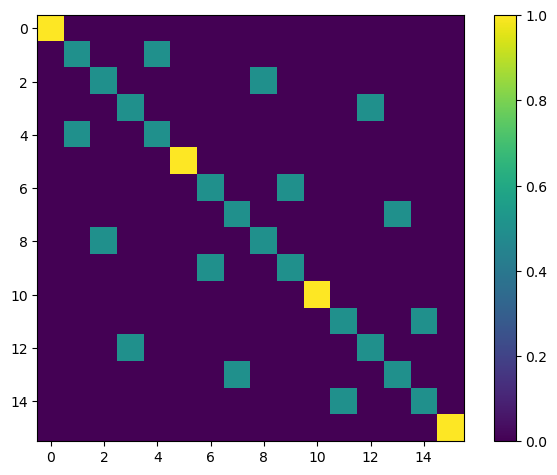

dima= 4 4
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Apr 14 04:31:18 PM: Your problem has 545 variables, 768 constraints, and 0 parameters.
(CVXPY) Apr 14 04:31:18 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 14 04:31:18 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 14 04:31:18 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 14 04:31:18 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 14 04:31:18 PM: Compiling problem (target solve

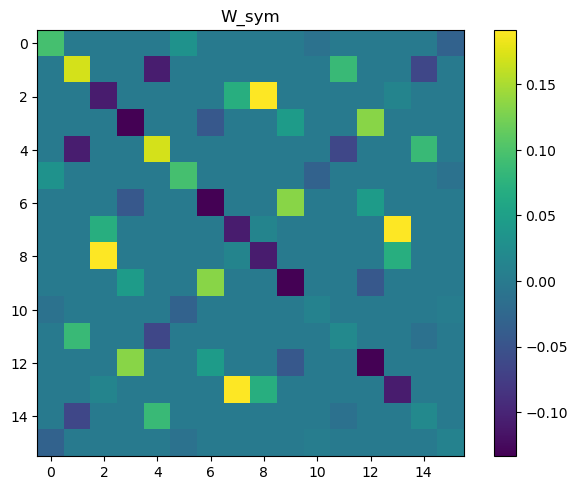

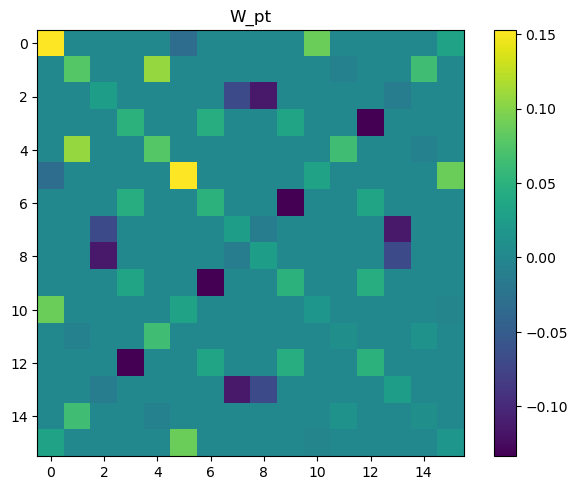

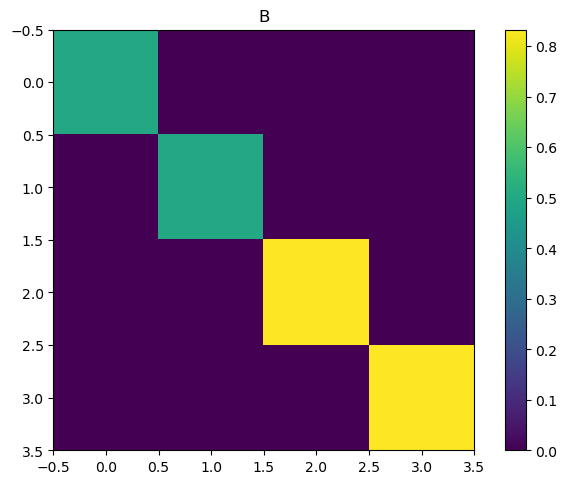

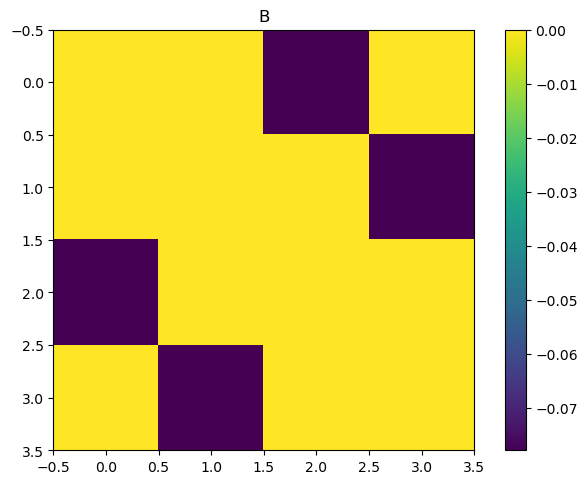

In [6]:
def sep_bound_ppt(obj_mat, constraint_mats, constants, rank):
    n = obj_mat.shape[0]
    labels = list(product(range(n), range(rank)))
    pairs = list(product(labels, labels))
    inv_pairs = {i: pair for i, pair in enumerate(pairs)}
    init_size = len(labels)
    size = len(pairs)
    P = cp.Variable((size, size), PSD=True)
    swap = get_swap_mat(pairs)
    proj = symmetry_projection(pairs)
    # visualize(swap)
    # visualize(swap - get_s)
    proj = symmetry_projection(pairs)
    visualize(proj)
    constraints = [cp.trace(P) == 1, swap @ P  == P, partial_transpose(P) == P]

    obj_mat = np.kron(obj_mat, np.eye(rank * init_size))
    constraint_mats = [
        np.kron(constraint_mat, np.eye(rank)) for constraint_mat in constraint_mats
    ]
    for constraint_mat, constant in zip(constraint_mats, constants):
        visualize(constraint_mat, title="C->" + str(constant))
        constraints += [
            apply_partial_2(P, constraint_mat)
            == constant * apply_partial_2(P, np.eye(init_size))
        ]
    opt_prob = cp.Problem(cp.Maximize(inner_mats(P, obj_mat)), constraints)
    print('opt:', opt_prob.solve(solver="MOSEK", verbose=True))
    
    return P.value
def sep_bound_ppt_dual(obj_mat, constraint_mats, constants, rank):
    n = obj_mat.shape[0]
    labels = list(product(range(n), range(rank)))
    pairs = list(product(labels, labels))
    inv_pairs = {i: pair for i, pair in enumerate(pairs)}
    init_size = len(labels)
    size = len(pairs)
    P = cp.Variable((size, size), PSD=True)
    swap = get_swap_mat(pairs)
    proj = symmetry_projection(pairs)
    visualize(proj)
    W_sym = cp.Variable((size, size), symmetric=True)
    W_pt = cp.Variable((size, size), symmetric=True)
    B = [cp.Variable((init_size, init_size)) for _ in constraint_mats]
    W = W_sym + W_pt
    constraints = [
        W_sym + swap @  W_sym >> 0,
        W_pt + partial_transpose(W_pt) >> 0
    ]
    t = cp.Variable() 
    big_obj = np.kron(obj_mat, np.eye(rank*init_size))
    constraint_mats = [
        np.kron(constraint_mat, np.eye(rank)) for constraint_mat in constraint_mats
    ]
    dual_first_mats = [
        constants[i] * cp.kron(np.eye(init_size), B[i]) for i in range(len(constraint_mats))
    ]
    dual_second_mats = [
        cp.kron(constraint_mats[i], B[i]) for i in range(len(constraint_mats))
    ]
    dual_first_mat = np.zeros_like(dual_first_mats[0])
    for mat in dual_first_mats:
        dual_first_mat = dual_first_mat + mat
    dual_second_mat = np.zeros_like(dual_first_mats[0])
    for mat in dual_second_mats:
        dual_second_mat = dual_second_mat + mat
    constraints += [
        W==-big_obj + t*np.eye(size) + dual_first_mat - dual_second_mat
    ]

    opt_prob = cp.Problem(cp.Minimize(t), constraints)
    opt_prob.solve(solver="SCS", verbose=True)
    return W_sym.value, W_pt.value, [b.value for b in B], t.value
    
def gen_sdp(obj_mat, constr_mats, constants):
    X = cp.Variable(obj_mat.shape, PSD=True)
    constraints = [
        cp.trace(constr_mat.T @ X) == const
        for constr_mat, const in zip(constr_mats, constants)
    ]
    constraints += [cp.trace(X) == 1]
    opt_prob = cp.Problem(cp.Maximize(cp.trace(obj_mat.T @ X)), constraints)
    opt_prob.solve(solver="MOSEK", verbose=True)
    print("opt=", opt_prob.value)
    return X.value


# obj_mat = np.array([[1,1,1],
#                     [1,0,0],
#                     [1,0,0]])
# C1 = np.array([[0,1,0],
#                [1,0,0],
#                [0,0,0]])
# C2 = np.array([
#     [0,0,1],
#     [0,0,0],
#     [1,0,0]])

obj_mat = np.array([[0, 0], [0, 1]])
C1 = np.array([[1, 0], 
               [0, -1/3]])
C2 = np.array([[0, 1], 
               [1, 0]])
constraint_mats = [C1, C2]
print(cp.sum(cp.vstack([C1, C2])).value)
# constr_mat = np.array([[1/3,   0],
# [-1,1/2]])
rank = 2
# X = gen_sdp(obj_mat, [C1, C2], [0, 0])

# P = sep_bound_ppt(obj_mat, [C1, C2], [0, 0], rank)
# P = sep_bound_ppt(obj_mat, [C1, C2], [0, 0], rank)
constants = [0,0]
gen = LinearFunctionalSDP( constraint_mats, constants, obj_mat)
gen.solve()
W_sym, W_pt, B, t = sep_bound_ppt_dual(obj_mat, [C1, C2], [0, 0], rank)
print('t', t)
visualize(W_sym, title="W_sym")
visualize(W_pt, title="W_pt")
for b in B:
    visualize(b, title="B")
# print(obj_mat)
# visualize(apply_partial_2(P, C1, NP=True))


In [7]:
sdp = SepLinearFunctionalSDP(constraint_mats, constants, obj_mat, rank=1)
sdp.solve(solver="MOSEK", verbose=True)
sdp.check(np.eye(2))
visualize(sdp.W)

NameError: name 'SepLinearFunctionalSDP' is not defined

## Via Span Solver 

In [8]:
n= 3
problem = threshold_k(n,2)

def span_sdp_from_mats(problem, p, sep=False, sep_dual=False, rank=None):
    a_size = problem.yes_len * problem.no_len
    constants = [p]* a_size + [1/problem.len]*problem.len
    constraint_mats = span_solver(problem, return_mats=True)
    obj = np.zeros([problem.len * n]*2)

    if sep_dual:
        return sep_bound_ppt_dual(obj, constraint_mats, constants, rank)
        
    else:
    
        # print(constants)
        gen = gen_sdp(obj, constraint_mats, constants)
        return gen

queries = 1
p = 1/(queries * problem.len)
gen = span_sdp_from_mats(problem, p)
visualize(gen)
# sepdual = span_sdp_from_mats(problem, p, sep_dual=True, rank=1)


In [9]:
W_sym, W_pt, B, t = sepdual
print(B[0].shape)
for m in [W_sym, W_pt] + B:
    visualize(m)

NameError: name 'sepdual' is not defined

[array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])]
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Apr 14 04:38:19 PM: Your problem has 16 variables, 3 constraints, and 0 parameters.
(CVXPY) Apr 14 04:38:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 14 04:38:19 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 14 04:38:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 14 04:38:19 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                           

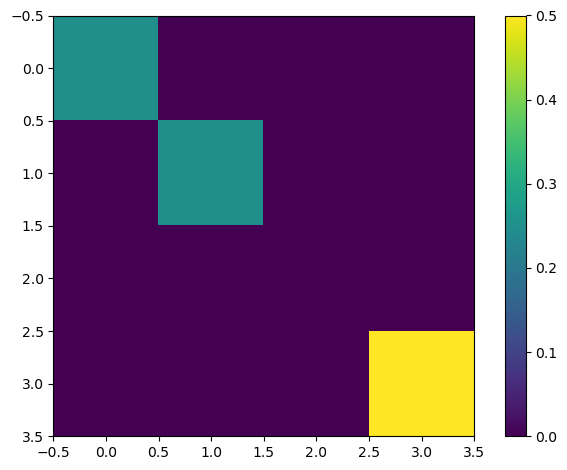

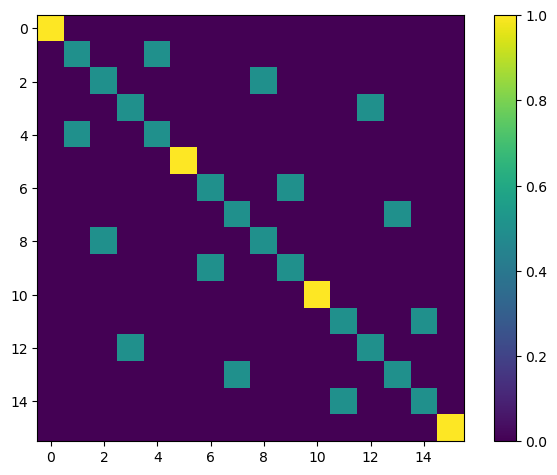

dima= 4 4
                                     CVXPY                                     
                                     v1.5.3                                    
(CVXPY) Apr 14 04:38:20 PM: Your problem has 545 variables, 768 constraints, and 0 parameters.
(CVXPY) Apr 14 04:38:20 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 14 04:38:20 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 14 04:38:20 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 14 04:38:20 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 14 04:38:20 PM: Compiling problem (target solve

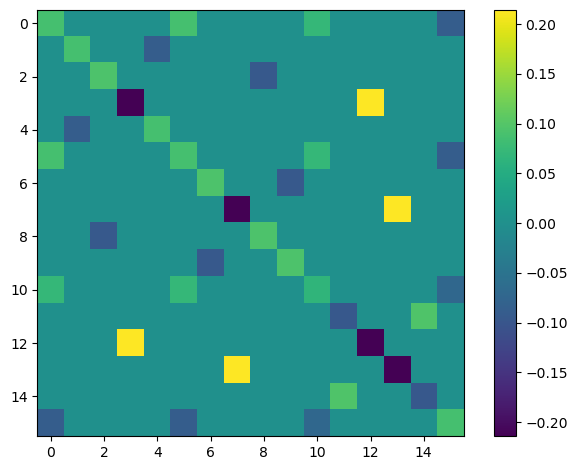

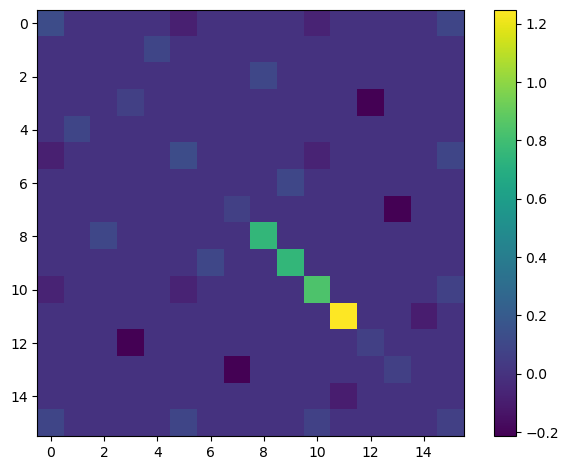

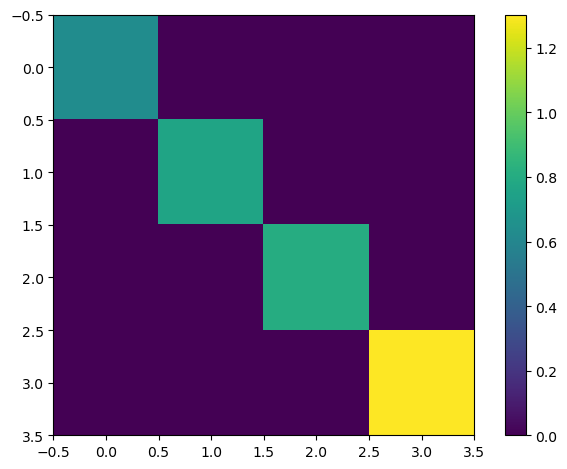

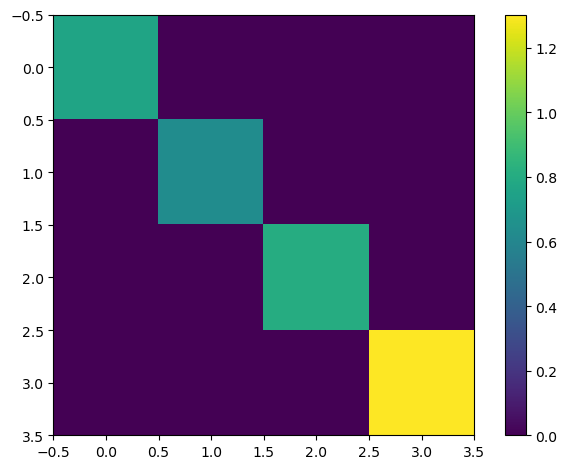

In [17]:
n = 4
rank = 2
eps = 1/n

constraint_mats = [
    np.zeros((n,n)) for _ in range(rank)
]
for i, m in enumerate(constraint_mats):
    m[i,i] = 1
print(constraint_mats)
obj_mat = np.zeros((n,n))
obj_mat[-1,-1] = 1
constants = [eps] * rank

gen = gen_sdp(obj_mat, constraint_mats, constants)
visualize(gen)
W_sym, W_pt, B, t = sep_bound_ppt_dual(obj_mat, constraint_mats, constants, rank=1)
for m in [W_sym, W_pt] + B:
    visualize(m)